# The spelled-out intro to neural networks and backpropagation: building micrograd

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Review of Derivatives

In [2]:
def f(x):
    return 3*x**2-4*x+5

In [3]:
f(3.0)

20.0

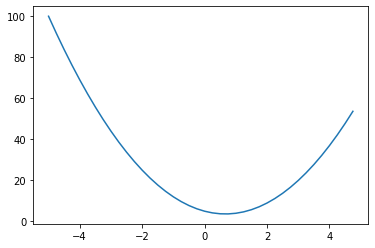

In [4]:
'''' We are going to plot the graph'''

xs = np.arange(-5,5,0.25) # an array of -5 to 5 in 0.25 steps
ys = f(xs)

plt.plot(xs,ys)

In [5]:
''' Find the derivative with Limits'''

h = 0.001
x = 3.0
(f(x + h) - f(x))/h

14.00300000000243

In [6]:
'''More complex'''

a = 2.0
b = -3.0
c = 10.0
d = a*b+c
print(d)

4.0


In [7]:
h = 0.0001

# inputs

a = 2.0
b = -3.0
c = 10.0

d1 = a*b+c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope',(d2-d1)/h)



d1 4.0
d2 4.0001
slope 0.9999999999976694


# Creating Micro Grad

In [8]:
class Value:
    def __init__(self, data,_children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self.grad = 0
        self._backward = lambda: None
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        out = Value(self.data + other.data, (self,other),'+')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out
    
    def __mul__(self,other):
        out = Value(self.data*other.data, (self,other),'*')
        
        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out._backward = _backward
        
        return out
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
        out = Value(t, (self,),'tanh')
        
        def _backward():
            self.grad += (1-t**2)*out.grad
        out._backward = _backward
        
        return out
    def backward(self):

        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


a = Value(2.0,label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d * f; L.label = 'L'
d


Value(data=4.0)

In [9]:
print(d._prev)
print(d._op)

print()

for value in d._prev:
    print(value)
    print(value._prev)
    print(value._op)

{Value(data=10.0), Value(data=-6.0)}
+

Value(data=10.0)
set()

Value(data=-6.0)
{Value(data=-3.0), Value(data=2.0)}
*


## Visualize the where values are coming from using graphviz

In [10]:
from graphviz import Digraph


def trace(root): 
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot



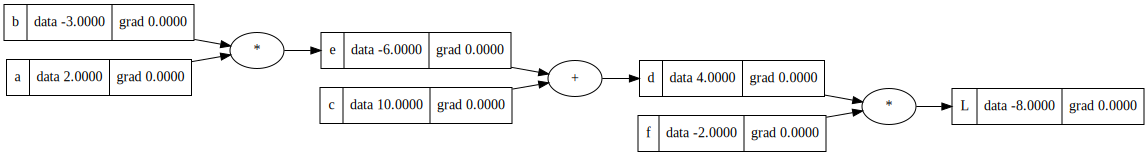

In [11]:
draw_dot(L)

## Investigating Derivatives and Gradients

### Dereivative of L with respect to f and d:

$$L = d * f$$

$$ \frac{dL}{dd}= f $$

$$ \frac{f(x+h)-f(x)}{h} $$

$$ \frac{(d+h)*f - d*f}{h}$$

$$\frac{d*f+h*f-d*f}{h}$$

$$\frac{h*f}{h}$$

$$f$$


In our example:

$f= -2$

$d = e + c = 4$

$e = -6$

$c=10$

$b = -3$

$a=2$


In [12]:
# In our example:

L.grad = 1.0
f.grad = 4.0
d.grad = -2

In [13]:
def manual_derivatives():
    
    h = 0.001
    
    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d * f; L.label ='L'
    L1 = L.data
    
    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d * f; L.label ='L'
    L2 = L.data+h
    
    print((L2-L1)/h)
    
manual_derivatives()

1.000000000000334


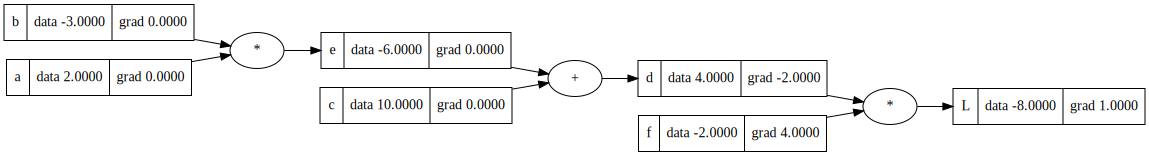

In [14]:
draw_dot(L)


### Dereivative of L with respect to c and e:

$$ \frac{dd}{dc} = ?$$

$$ d = c + e$$

$$ \frac{f(x+h)-f(x)}{h} $$

$$ \frac{c+h+e - (c+3)}{h}$$

$$ \frac{c+h+e-c-e}{h} $$

$$ \frac{h}{h}$$

$$ 1.0 $$


$$ \frac{dd}{de} = 1..0$$


### Chain Rule  to find $dL/dC$


Want:
$\frac{dL}{dc} = \frac{dL}{dd} * \frac{dd}{dc}$

Know:
$\frac{dL}{dd}$
$\frac{dd}{dc}$


In our example is:


In [15]:
c.grad = -2.0
e.grad = -2.0

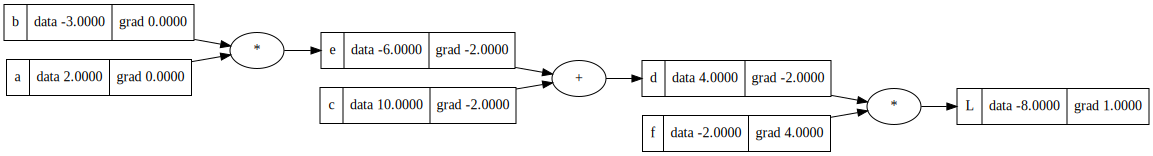

In [16]:
draw_dot(L)

### Finding the derivative for $\frac{dL}{da}$

Using Chain rule that is:

$$ \frac{dL}{da} = \frac{dL}{de} * \frac{de}{da} $$

Since $$e = a * b, \frac{de}{da} = b$$

$$ \frac{dL}{da} = -2*3$$



In [17]:
a.grad = -2.0 * 3.0
b.grad = -2.0 *2.0

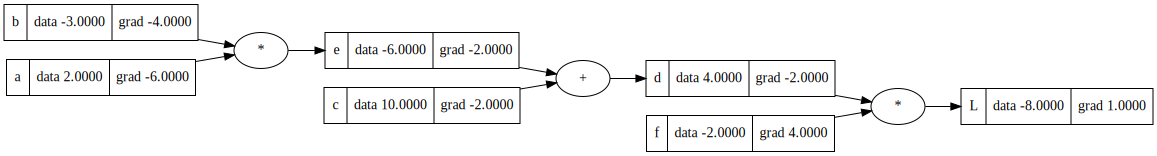

In [18]:
draw_dot(L)

## Another function: tanh

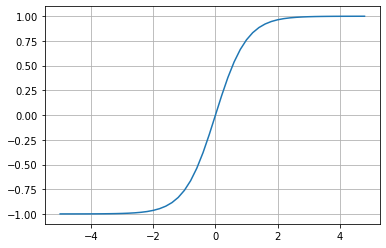

In [19]:
plt.plot(np.arange(-5,5,0.2),np.tanh(np.arange(-5,5,0.2))); plt.grid();

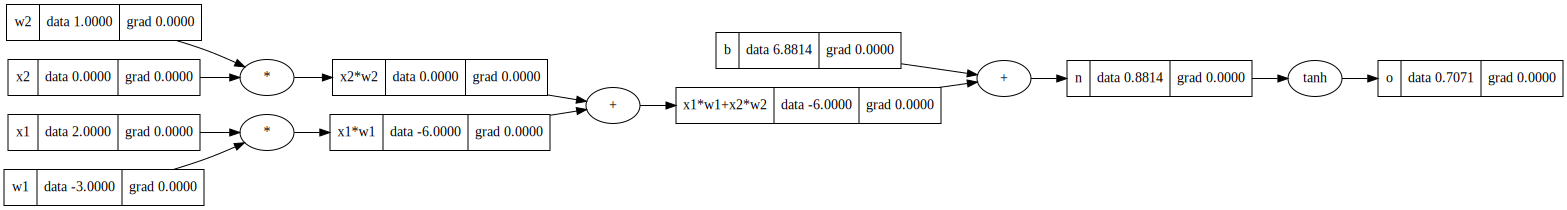

In [20]:
# inputs  x1 x2
# weights w1 w2


x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
b = Value(6.8813735870195432, label = 'b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1+x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

draw_dot(o)

In [21]:
o.grad = 1.0

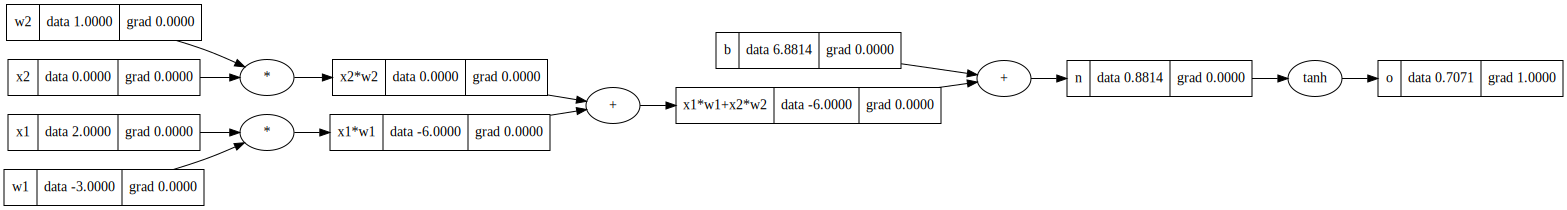

In [22]:
draw_dot(o)

### Derivative with respect to n: $\frac{do}{dn}$

$$ o = tanh(n)$$

$$\frac{do}{dn} = 1 - tanh(n)^2$$


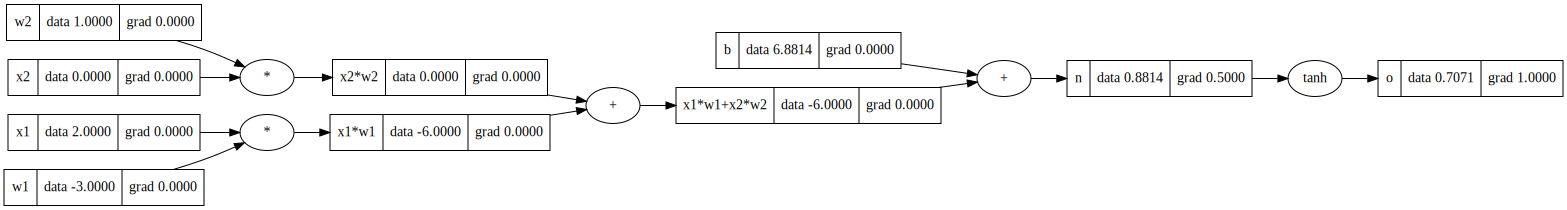

In [23]:
n.grad = 1-o.data**2

draw_dot(o)

### Derivative with respect to b: $\frac{do}{b}$ and $\frac{do}{x1*w1+x2*w2}$

Chain rule

In [24]:
x1w1x2w2.grad = n.grad
b.grad = n.grad

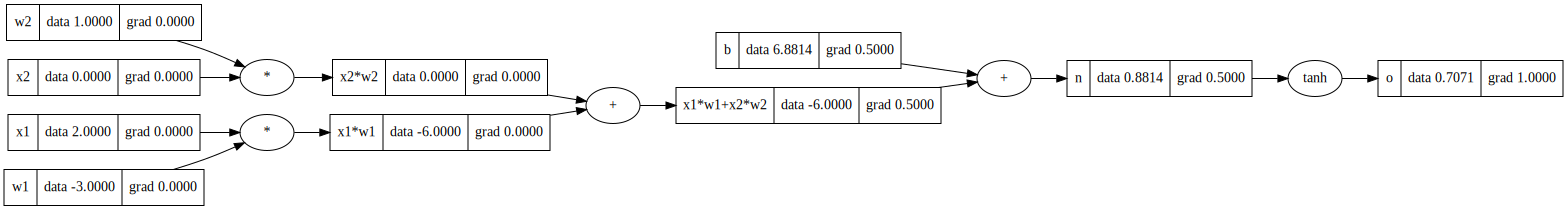

In [25]:
draw_dot(o)

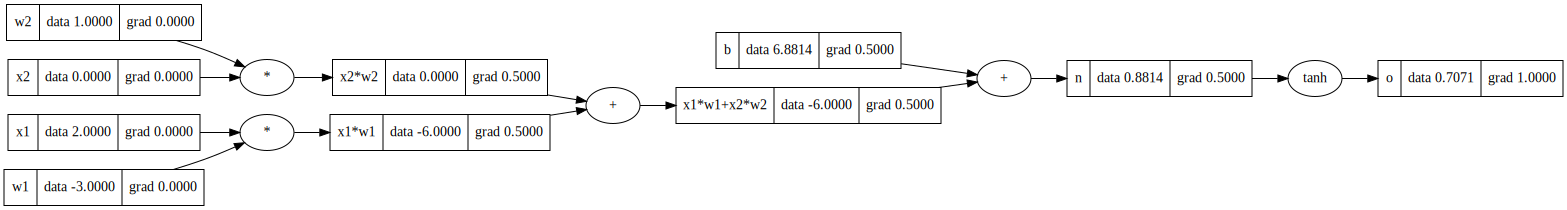

In [26]:
x1w1.grad = n.grad
x2w2.grad = n.grad

draw_dot(o)

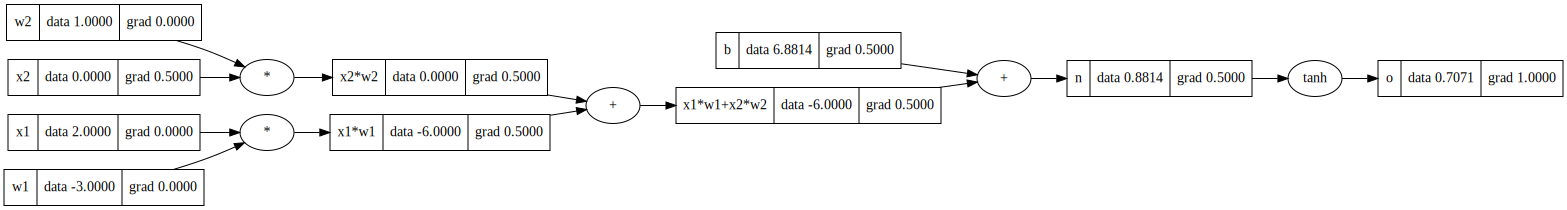

In [27]:
x2.grad = w2.data*x2w2.grad
w2.grad = x2.data*x2w2.grad

draw_dot(o)

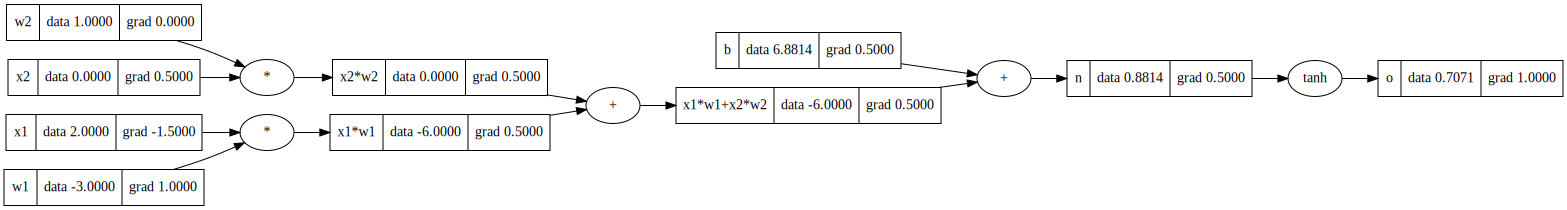

In [28]:
x1.grad = w1.data*x1w1.grad
w1.grad = x1.data*x1w1.grad

draw_dot(o)

### Using the function:

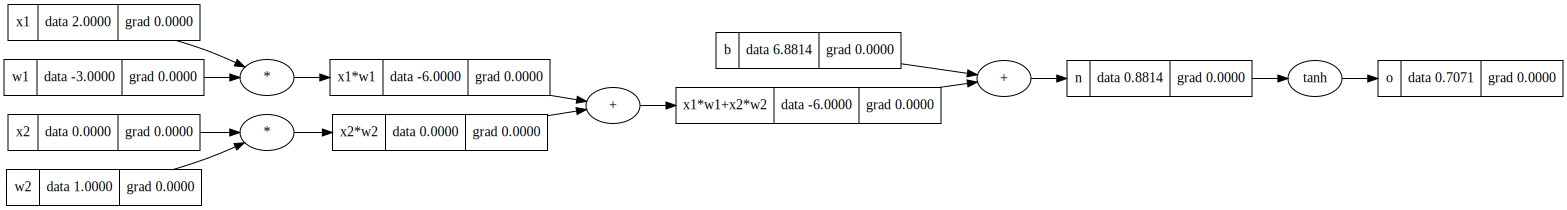

In [29]:
# inputs  x1 x2
# weights w1 w2


x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
b = Value(6.8813735870195432, label = 'b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1+x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

draw_dot(o)

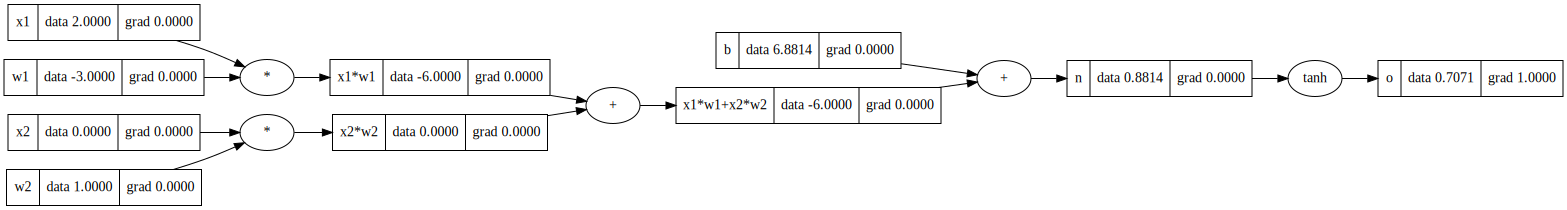

In [30]:
o.grad = 1.0

draw_dot(o)

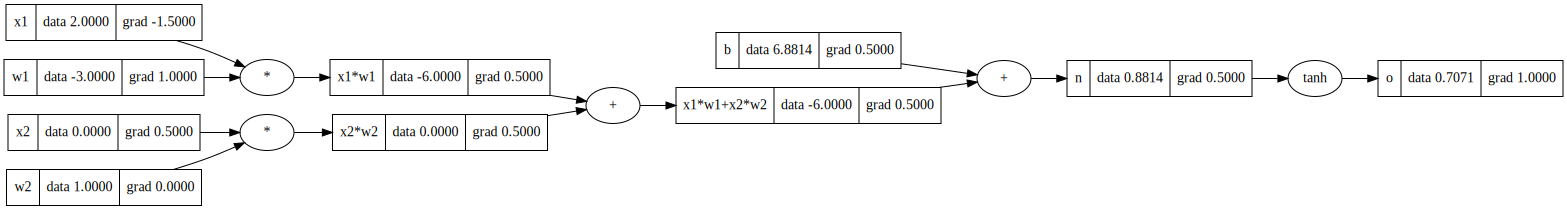

In [31]:
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()
draw_dot(o)

### Building a topological graph so we always work backwards to find the gradients



In [32]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo


[Value(data=6.881373587019543),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

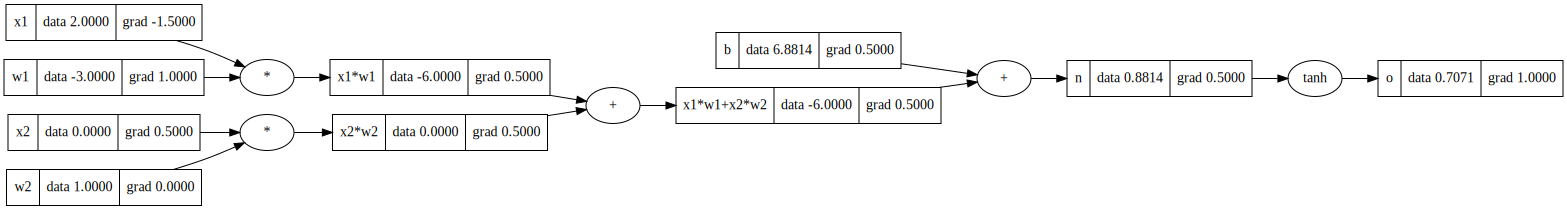

In [33]:
draw_dot(o)

In [34]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()


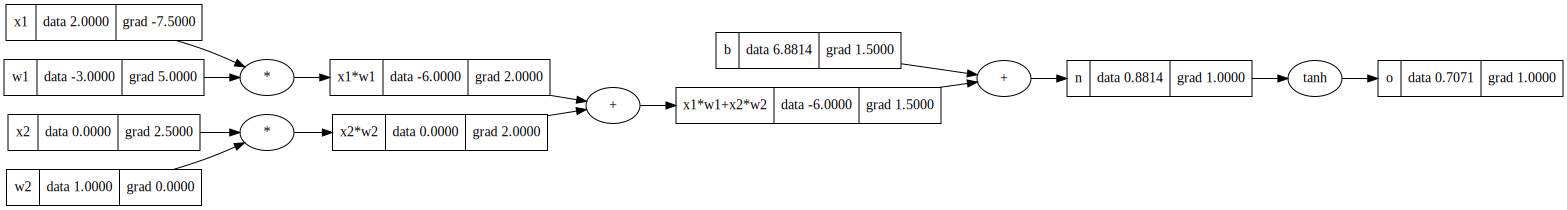

In [35]:
draw_dot(o)

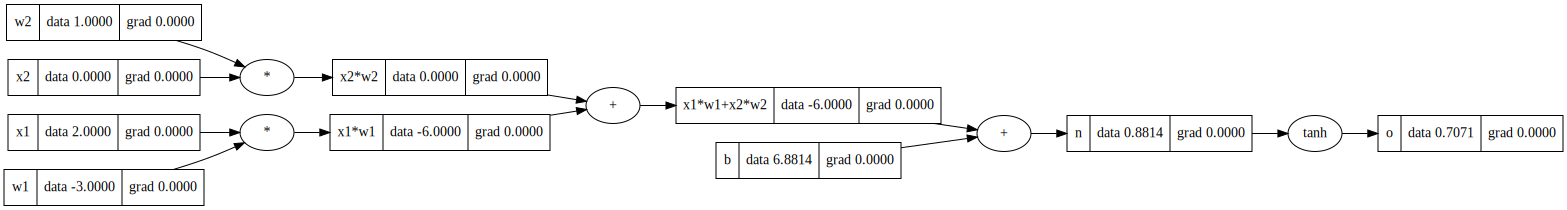

In [36]:
# Test:

x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
b = Value(6.8813735870195432, label = 'b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1+x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

draw_dot(o)

In [37]:
o.backward()

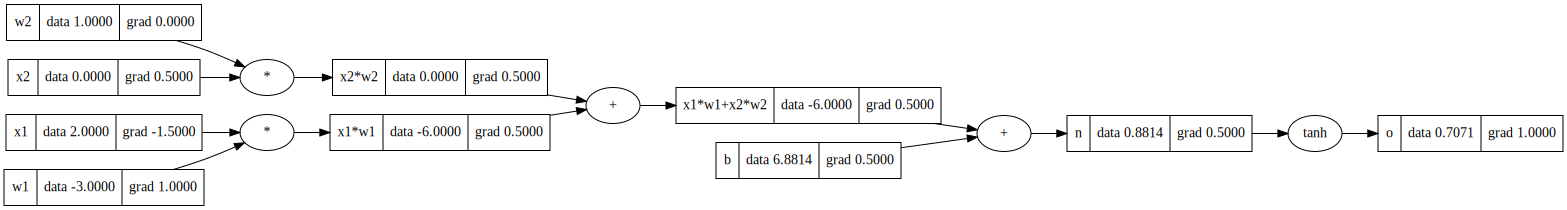

In [38]:
draw_dot(o)

## There is a bug

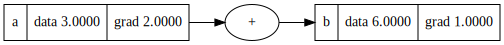

In [39]:
a = Value(3.0, label='a')
b = a + a ; b.label = 'b'
b.backward()
draw_dot(b)

# if we use a variable more than once there is a problem
# so we do +=

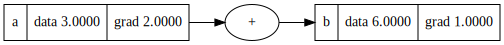

In [40]:
a = Value(3.0, label='a')
b = a + a ; b.label = 'b'
b.backward()
draw_dot(b)


## Using other operations for Tanh

In [41]:
class Value:
    def __init__(self, data,_children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self.grad = 0
        self._backward = lambda: None
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other),'+')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out
    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data*other.data, (self,other),'*')
        
        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out._backward = _backward
        
        return out
    
    def __pow__(self,other):
        assert isinstance(other, (int,float)),"only int of float powers"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * self.data**(other - 1) * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self,other): # other*self
        return self*other
    
    def __truediv__(self,other): # self / other
        return self * other**-1
    
    def __neg__(self): #-self
        return self*-1
    
    def __sub__(self,other): # self - other
        return self+(-other)
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
        out = Value(t, (self,),'tanh')
        
        def _backward():
            self.grad += (1-t**2)*out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad += out.data*out.grad
        out._backward = _backward
        
        return out
            
    def backward(self):

        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [42]:
# This doesn't work so we have to fix it: Addition, Subtraction, Multiplication and Divsion

a = Value(2.0)

2*a

Value(data=4.0)

In [43]:
a.exp()

Value(data=7.38905609893065)

In [44]:
# Division: instead of implimenting division, we will impliment powers so we can take something to the power of -1 
#           and then multiply

a = Value(2.0)
b = Value(4.0)

print(a/b)

print(a*(b**-1))

a-b

 

Value(data=0.5)
Value(data=0.5)


Value(data=-2.0)

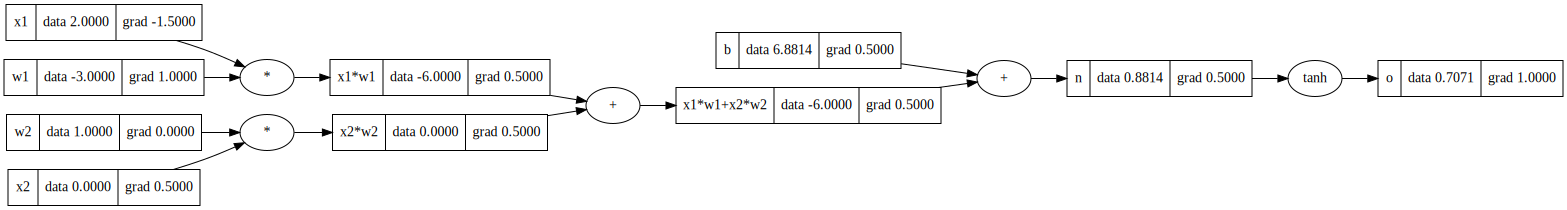

In [45]:
# Old one:

# inputs weights and bias

x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
b = Value(6.8813735870195432, label = 'b')

# x1*w1+x2*w2+b

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1+x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

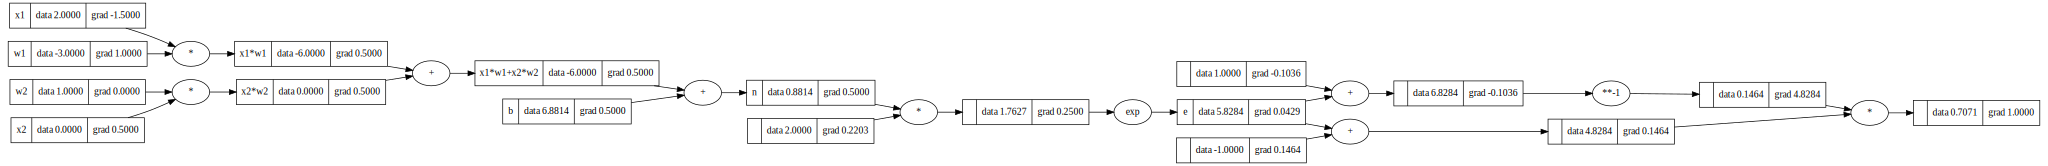

In [46]:
# Breaking tanh:
# inputs weights and bias

x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
b = Value(6.8813735870195432, label = 'b')

# x1*w1+x2*w2+b

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1+x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# --------
e = (2*n).exp(); e.label = 'e'
o = (e-1)/(e+1); o.lable = 'o'
#---------


o.backward()
draw_dot(o)


## Doing the same thing with PyTorch

In [1]:
import torch

OSError: [WinError 126] The specified module could not be found. Error loading "C:\Users\preet\anaconda3\lib\site-packages\torch\lib\caffe2_nvrtc.dll" or one of its dependencies.

In [52]:
x1 = torch.Tensor([2.0]).double()                         ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                         ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                        ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                         ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()           ; b.requires_grad = True

n=x1*w1+x2*w2+b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737
